<a id="summary"></a>
# GfG Data Science Challenge: Swiggy Dataset Analysis
Author: Arun Ganapathy (arun98.aol@gmail.com) <br>
Date  : 5th August 2023
## Overview

Exploratory Analysis + Questions asked

1. [How many cities (including subregions) have Swiggy restaurants listed?](#q1)
2. [How many cities (excluding subregions) have Swiggy restaurants listed?](#q2)
3. [Which Subregion of Delhi has the maximum number of restaurants listed on Swiggy?](#q3)
4. [Name the top 5 Most Expensive Cities in the Datasets.](#q4)
5. [List out the top 5 Restaurants with Maximum & Minimum ratings throughout the dataset.](#q5)
6. [Name the top 5 cities with the highest number of restaurants listed.](#q6)
7. [List the Top 10 cities as per the number of restaurants listed.](#q7)
8. [Name the top 5 Most Popular Restaurants in Pune.](#q8)
9. [Which SubRegion in Delhi has the least expensive restaurant in terms of cost?](#q9)
10. [List the Top 5 most popular restaurant chains in India.](#q10)
11. [Which restaurant in Pune has the most number of people visiting?](#q11)
12. [List the Top 10 Restaurants with Maximum Ratings in Bangalore.](#q12)
13. [List the Top 10 Restaurants in Patna with the highest ratings.](#q13)

Note: Tasks marked with a link have been completed.


## Data Exploration & Manipulation

1. Understanding the data structure and key hierarchy
2. Manipulate data as required and save it as a parquet file if required

In [1]:
import pandas as pd
import json
import numpy as np
import multiprocessing as mp
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import warnings

def apply_common_styling(df):
    rounded_df = df.round(2)

    styled_df = rounded_df.style.set_table_styles([
        {'selector': 'thead',
         'props': [('background-color', 'skyblue'),
                   ('font-size', '14px'),
                   ('font-weight', 'bold')]},
        {'selector': 'tbody',
         'props': [('font-size', '12px')]},
        {'selector': 'th',
         'props': [('text-align', 'center'),
                   ('font-size', '12px')]},
        {'selector': 'td',
         'props': [('text-align', 'left')]},
        {'selector': '.row_heading',
         'props': [('display', 'none')]},
        {'selector': '.blank.level0',
         'props': [('display', 'none')]}
    ])
    
    return styled_df

### <i>Notes</i>

Visible Hierarchy

<code>FOR EACH CITY:
    IF no sub-region:
        - city -> link or restaurants #FOR full description of each restaurant
    IF sub-region
        - city -> sub-regions -> link -> restaurants #FOR summary of each restauran
        - city -> sub-regions -> restaurants #FOR full description of each restaurant
</code>

DATA CLEANING:

- City "Hinganghat" -> Restaurant "KOHINOOR HOTEL" removed (reason: permanently closed and data entry issue)<br><br>

- Current state of cost data:

    1. '₹ ' - predecessor
    2. '₹'  - predecessor and ' FOR TWO' - successor
    3. 'NA' - null values

In [2]:
# create a clean parquet file (quicker reading -> file size)
# use the hierarchy above to extract restaurants from the data (this auto excludes keys that have nothing listed)
# use multi-processing
def rest_from_city(city):
    rest_df = pd.DataFrame(columns=['city', 'sub-region', 'level', 'restaurant', 'cost', 'rating', 'rating_count'])
    temp = {}
    if 'restaurants' in data[city].keys():
        temp['city'] = city
        temp['level'] = 'city'
        rest_ids = data[city]['restaurants'].keys()
        if len(rest_ids):
            for rest in rest_ids:
                temp['restaurant'] = data[city]['restaurants'][rest]['name']
                if 'cost' in data[city]['restaurants'][rest].keys():
                    temp['cost'] = data[city]['restaurants'][rest]['cost']
                else: 
                    temp['cost'] = data[city]['restaurants'][rest]['price']
                temp['rating'] = data[city]['restaurants'][rest]['rating']
                if 'rating_count' not in data[city]['restaurants'][rest].keys() or temp['rating'] == '--':
                    temp['rating_count'] = 'not enough ratings'
                else:
                    temp['rating_count'] = data[city]['restaurants'][rest]['rating_count']
                rest_df = rest_df.append(temp, ignore_index=True)
    else:
        sub_regions = list(data[city].keys())
        temp['city'] = city
        temp['level'] = 'sub-region'
        sub_regions.remove('link')
        for subr in sub_regions:
            temp['sub-region'] = subr
            rest_ids = data[city][subr]['restaurants'].keys()
            if len(rest_ids):
                for rest in rest_ids:
                    temp['restaurant'] = data[city][subr]['restaurants'][rest]['name']
                    if 'cost' in data[city][subr]['restaurants'][rest].keys():
                        temp['cost'] = data[city][subr]['restaurants'][rest]['cost']
                    else: 
                        temp['cost'] = data[city][subr]['restaurants'][rest]['price']
                    temp['rating'] = data[city][subr]['restaurants'][rest]['rating']
                    if 'rating_count' not in data[city][subr]['restaurants'][rest].keys() or temp['rating'] == '--':
                        temp['rating_count'] = 'not enough ratings'
                    else:
                        temp['rating_count'] = data[city][subr]['restaurants'][rest]['rating_count']
                    rest_df = rest_df.append(temp, ignore_index=True)
    return rest_df

###################################################################################################################

if (os.path.isfile('../data/restaurant_raw.parquet')): 
    rest_df = pd.read_parquet('../data/restaurant_raw.parquet')
else:
    # read the dataset
    with open('../data/data.json', 'r') as file:
        data = json.load(file)
    cities = data.keys() # CITIES
    rest_df = pd.DataFrame(columns=['city', 'sub-region', 'level', 'restaurant', 'cost', 'rating', 'rating_count'])
    pool = mp.Pool(os.cpu_count()-1) 
    with tqdm(total=len(cities), desc="Processing cities") as pbar:
        for city_df in pool.imap_unordered(rest_from_city, cities):
            rest_df = pd.concat([rest_df, city_df], ignore_index=True)
            pbar.update(1)
    pool.close()
    pool.join()
    
    # Handling 1
    rest_df['cost_val'] = rest_df.cost.apply(lambda x: float(x.split()[1]) 
                                          if (type(x) == str and x[0] == '₹' and len(x.split()) == 2) 
                                          else x)
    # Handling 3
    rest_df['cost_val'] = rest_df.cost_val.apply(lambda x: None if x == 'NA' else x)

    # Handling 2 (other costs for 1 probably, so divide by 2)
    rest_df['cost_val'] = rest_df.cost_val.apply(lambda x: float(x.split('₹')[1].split()[0])/2 
                                          if (type(x) == str and x[0] == '₹' and len(x.split()) != 2) 
                                          else x)
    # saving the raw data
    rest_df.to_parquet('../data/restaurant_raw.parquet', index = False)

display(apply_common_styling(rest_df.round(2).head()))

,city,sub-region,level,restaurant,cost,rating,rating_count,cost_val
0,Bantwal,None,city,Krishnima Veg,₹ 200,4.1,50+ ratings,200.000000
1,Bantwal,None,city,Aania Darbar,₹ 200,3.8,50+ ratings,200.000000
2,Bantwal,None,city,Sanman Bar and Restaurant,₹ 200,4.0,100+ ratings,200.000000
3,Bantwal,None,city,Chikori Bar and Restaurant,₹ 200,3.8,50+ ratings,200.000000
4,Bantwal,None,city,Laziz pizza,₹ 300,3.8,50+ ratings,300.000000


In [3]:
# drop KOHINOOR - explained above
index_to_drop = rest_df[(rest_df.city == 'Hinganghat') & (rest_df.restaurant == "KOHINOOR HOTEL")].index
rest_df.drop(index_to_drop, inplace=True)

In [4]:
# Calculate the percentage of null values in each column
null_percentage = (rest_df.isnull().sum() / len(rest_df)) * 100
# Create a DataFrame to display the null percentage for each column
null_percentage_df = pd.DataFrame({'Column': null_percentage.index, 'Null Percentage': null_percentage.values})
# Sort the DataFrame by null percentage in descending order
null_percentage_df = null_percentage_df.sort_values(by='Null Percentage', ascending=False)
# Display the DataFrame
print(null_percentage_df)

         Column  Null Percentage
1    sub-region        32.432763
7      cost_val         0.092382
0          city         0.000000
2         level         0.000000
3    restaurant         0.000000
4          cost         0.000000
5        rating         0.000000
6  rating_count         0.000000


In [5]:
# drop NA in cost_val column
rest_df = rest_df.dropna(subset=['cost_val'])
display(apply_common_styling(rest_df.round(2).head()))

,city,sub-region,level,restaurant,cost,rating,rating_count,cost_val
0,Bantwal,None,city,Krishnima Veg,₹ 200,4.1,50+ ratings,200.000000
1,Bantwal,None,city,Aania Darbar,₹ 200,3.8,50+ ratings,200.000000
2,Bantwal,None,city,Sanman Bar and Restaurant,₹ 200,4.0,100+ ratings,200.000000
3,Bantwal,None,city,Chikori Bar and Restaurant,₹ 200,3.8,50+ ratings,200.000000
4,Bantwal,None,city,Laziz pizza,₹ 300,3.8,50+ ratings,300.000000


<a id = "q1"></a>
## Question 1
How many cities (including subregions) where Swiggy is having its restaurants listed?

Assumptions: This count would not include cities/sub-regions where there are no restaurants listed

In [6]:
cities = set(rest_df.city)
sub_regions = set(rest_df['sub-region'].dropna())
total_cities = len(cities) + len(sub_regions)

markdown_content = f"**Total no of cities (including subregions) where Swiggy is having its restaurants listed:** \
                    {total_cities}"
display(Markdown(markdown_content))

**Total no of cities (including subregions) where Swiggy is having its restaurants listed:**                     863

<a id = "q2"></a>
## Question 2
How many cities (don't include subregions) where Swiggy is having their restaurants listed?

In [7]:
markdown_content = f"**No of cities with restaurants listed:** {len(set(rest_df.city.dropna()))}"
display(Markdown(markdown_content))

**No of cities with restaurants listed:** 556

<a id = "q3"></a>
## Question 3
The Subregion of Delhi with the maximum number of restaurants listed on Swiggy?

In [8]:
delhi_df = rest_df[rest_df.city == 'Delhi']
delhi_df = delhi_df.groupby(['city', 'sub-region']).agg(restaurant_count=('restaurant', 'count')).reset_index()
delhi_df.sort_values(by = 'restaurant_count', ascending = False, inplace = True)

markdown_content = f"**Delhi Sub-Region(max restaurants):** {delhi_df['sub-region'].head(1).values[0]}"
display(Markdown(markdown_content))

**Delhi Sub-Region(max restaurants):** Indirapuram

<a id = "q4"></a>
## Question 4
Name the top 5 Most Expensive Cities in the Datasets.  

For this business question, I have included only cities that have atleast the average no of restaurants by city to ensure an un-skewed distribution

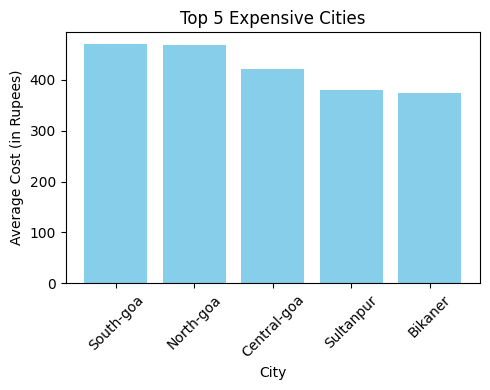

In [9]:
def normalize_column(column):
    min_val = column.min()
    max_val = column.max()
    return (column - min_val) / (max_val - min_val)

rest_df4 = rest_df.groupby(['city']).agg(
        mean_cost=('cost_val', 'mean'),
        restaurant_count=('cost_val', 'count')
    ).reset_index()

expensive_cities = rest_df4.copy()
expensive_cities['mean_cost_N'] = normalize_column(expensive_cities['mean_cost'])
expensive_cities['restaurant_count_N'] = normalize_column(expensive_cities['restaurant_count'])

expensive_cities = expensive_cities[expensive_cities.restaurant_count >= expensive_cities.restaurant_count.mean()].sort_values(\
        by = ['mean_cost_N', 'restaurant_count_N'], ascending=False).head(5)

plt.figure(figsize=(5, 4))
plt.bar(expensive_cities['city'].head(5), expensive_cities['mean_cost'].head(5), color='skyblue')
plt.title('Top 5 Expensive Cities')
plt.xlabel('City')
plt.ylabel('Average Cost (in Rupees)')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

<a id = "q5"></a>
## Question 5

List out the top 5 Restaurants with Maximum & minimum ratings throughout the dataset.

many restaurants with same ratings, create a weighted score to break the tie

In [10]:
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)
def normalize_column(column):
    min_val = column.min()
    max_val = column.max()
    return (column - min_val) / (max_val - min_val)

# filtering out only restaurants with enough rating
# if required skip the next step
# assumption is that the business question is to understand which restaurants have the lowest user ratings. 
# hence restaurants that don't have any ratings have been disconsidered
rest_df2 = rest_df[rest_df.rating_count != 'not enough ratings']
rest_df2['rating_count_val'] = rest_df2.rating_count.apply(lambda x: x.split("+")[0])
rest_df2 = rest_df2[rest_df2.rating_count_val != 'NA']

map_rating = {'1K': 1000, '5K': 5000, '10K': 10000}
rest_df2.rating_count_val = rest_df2.rating_count_val.apply(lambda x: map_rating[x] if x in map_rating.keys() else int(x))
rest_df2['rating_count_val'] = rest_df2['rating_count_val'].astype('int')
rest_df2['rating'] = rest_df2['rating'].astype('float')

# Calculate the weighted score using a weighted average
rest_df2['rating_norm'] = normalize_column(rest_df2['rating'])
rest_df2['rating_count_val_norm'] = normalize_column(rest_df2['rating_count_val'])

top_5_max_ratings = rest_df2.sort_values(by=['rating', 'rating_count_val'], ascending=False).head(5)[['restaurant', 
                                                                                                     'rating',
                                                                                                     'rating_count_val']]

top_5_min_ratings = rest_df2.sort_values(by=['rating', 'rating_count_val'], ascending=True).head(5)[['restaurant', 
                                                                                                     'rating',
                                                                                                     'rating_count_val']]

markdown_content = '**Top 5 - Max Ratings:**'
display(Markdown(markdown_content))
display(apply_common_styling(top_5_max_ratings.round(2).head()))
markdown_content = '**Top 5 - Min Ratings:**'
display(Markdown(markdown_content))
display(apply_common_styling(top_5_min_ratings.round(2).head(5)))
# # Create subplots for the two horizontal bar charts
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# # Horizontal bar plot for Top 5 Restaurants with Maximum Ratings
# ax1.barh(top_5_max_ratings['restaurant'], top_5_max_ratings['rating_count_val'], color='skyblue')
# ax1.set_title('Top 5 Restaurants with Maximum Ratings')
# ax1.set_xlabel('Rating')
# ax1.set_ylabel('Restaurant')
# ax1.invert_yaxis()  # Invert y-axis to have the highest rated restaurant at the top

# # Horizontal bar plot for Top 5 Restaurants with Minimum Ratings
# ax2.barh(top_5_min_ratings['restaurant'], top_5_min_ratings['rating_count_val'], color='lightcoral')
# ax2.set_title('Top 5 Restaurants with Minimum Ratings')
# ax2.set_xlabel('Rating')
# ax2.set_ylabel('Restaurant')
# ax2.invert_yaxis()  # Invert y-axis to have the lowest rated restaurant at the top

# # Adjust layout for better spacing between subplots
# plt.tight_layout()

# # Display the plots
# plt.show()
warnings.resetwarnings()

**Top 5 - Max Ratings:**

,restaurant,rating,rating_count_val
15399,SHRI KRISHNA FOOD ZONE,5.000000,100
80023,Tony Bakery,5.000000,100
31818,SHREE SAMARTHA CHAPATIS,5.000000,50
115465,Bento It,5.000000,50
139185,Gelato Vinto,5.000000,50


**Top 5 - Min Ratings:**

,restaurant,rating,rating_count_val
67713,Ice Cream and Shakes Co,1.000000,20
157849,Persian Delight,1.100000,20
55694,Champaran Mutton Hundy & Biryani,1.200000,20
76924,The Hyderabadi Biryani House,1.200000,20
137944,THE TARI STORY,1.200000,20


<a id = "q6"></a>
## Question 6

Name of top 5 cities with the highest number of restaurants listed.

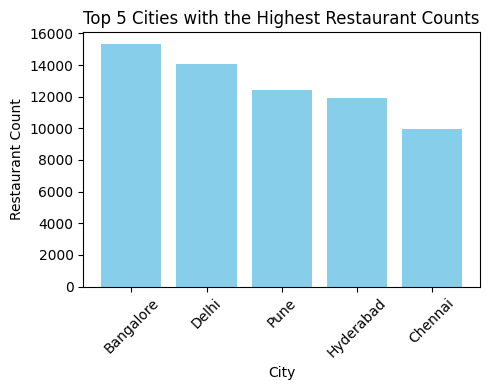

In [11]:
city_df = rest_df4.sort_values(by='restaurant_count', ascending = False).reset_index(drop = True)
plt.figure(figsize=(5, 4))
plt.bar(city_df['city'].head(5), city_df['restaurant_count'].head(5), color='skyblue')
plt.title('Top 5 Cities with the Highest Restaurant Counts')
plt.xlabel('City')
plt.ylabel('Restaurant Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

<a id = "q7"></a>
## Question 7

Top 10 cities as per the number of restaurants listed?

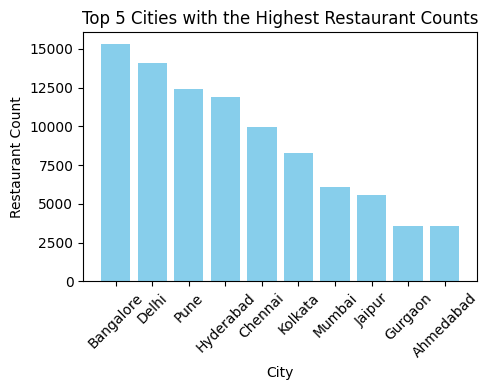

In [12]:
city_df = rest_df4.sort_values(by='restaurant_count', ascending = False).reset_index(drop = True)
plt.figure(figsize=(5, 4))
plt.bar(city_df['city'].head(10), city_df['restaurant_count'].head(10), color='skyblue')
plt.title('Top 5 Cities with the Highest Restaurant Counts')
plt.xlabel('City')
plt.ylabel('Restaurant Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

<a id = "q8"></a>
## Question 8
Name the top 5 Most Popular Restaurants in Pune.

In [13]:
rest_df2['popularity_score'] = (rest_df2['rating_norm'] * 0.8) + (rest_df2['rating_count_val_norm'] * 0.2)
pune_popular = rest_df2[rest_df2.city == 'Pune']
pune_popular = pune_popular.sort_values(by = ['popularity_score'], ascending = False).head(5)\
            [['restaurant', 'rating', 'rating_count','popularity_score']]

markdown_content = '**Top 5 by Popularity in Pune:**'
display(Markdown(markdown_content))
display(apply_common_styling(pune_popular.round(2)))

**Top 5 by Popularity in Pune:**

,restaurant,rating,rating_count,popularity_score
130128,Smoodies & Juices: Your Fruitfully,5.000000,20+ ratings,0.800000
129988,Paratha Box by EatFit,5.000000,20+ ratings,0.800000
131339,Miss Gelato,5.000000,20+ ratings,0.800000
130238,HRX by Eatfit,5.000000,20+ ratings,0.800000
131398,Kushta by Semporo,5.000000,20+ ratings,0.800000


<a id = "q9"></a>
## Question 9
Which SubRegion in Delhi is having the least expensive restaurant in terms of cost?

In [14]:
rest_df9 = rest_df2[rest_df2.city == 'Delhi']
# rest_df9.sort_values(by = 'cost_val').head(1)[['city', 'sub-region', 'cost_val']]
markdown_content = f"**Delhi Sub-Region (least expensive restaurants):** {rest_df9.sort_values(by = 'cost_val').head(1)['sub-region'].values[0]}"
display(Markdown(markdown_content))

**Delhi Sub-Region (least expensive restaurants):** GTB Nagar

<a id = "q10"></a>
## Question 10
Top 5 most popular restaurant chains in India?

In [15]:
rest_df10 = rest_df2.groupby(['restaurant']).agg({
    'rating': 'mean',
    'rating_count_val': 'sum'  # sum as we assume this field to give us information about the # of people visiting
}).reset_index()

rest_df10['rating_norm'] = normalize_column(rest_df10['rating'])
rest_df10['rating_count_val_norm'] = normalize_column(rest_df10['rating_count_val'])
rest_df10['popularity_score'] = (rest_df10['rating_norm'] * 0.7) + (rest_df10['rating_count_val_norm'] * 0.3)

rest_df10 = rest_df10.sort_values(by = ['popularity_score'], ascending = False).head(5)\
    [['restaurant', 'rating', 'rating_count_val','popularity_score']]

markdown_content = '**Top 5 by Popularity in India:**'
display(Markdown(markdown_content))
display(apply_common_styling(rest_df10.round(2)))

**Top 5 by Popularity in India:**

,restaurant,rating,rating_count_val,popularity_score
22703,McDonald's,4.190000,133950,0.860000
5916,Burger King,4.120000,118950,0.810000
18204,KFC,3.940000,122040,0.790000
24300,NIC Natural Ice Creams,4.510000,72070,0.780000
458,A2B Veg,4.230000,61900,0.700000


<a id = "q11"></a>
## Question 11

Which restaurant in Pune has the most number of people visiting?
(to break the tie, popularity score is used)

In [16]:
rest_df11 = rest_df2[rest_df2.city == 'Pune']
rest_df11 = rest_df11.sort_values(by = ['rating_count_val', 'rating', 'cost_val'], ascending = [False, False, True]).head(1)
markdown_content = f"**Pune (most visited restaurant):** {rest_df11['restaurant'].values[0]}"
display(Markdown(markdown_content))

**Pune (most visited restaurant):** Kalika Dairy & Sweets

<a id = "q12"></a>
## Question 12
Top 10 Restaurants with Maximum Ratings in Banglore

 - When we say "maximum ratings", we should have enough ratings as well. 
 - Hence let's filter this df before running the analysis
 - This filter could be based on a condition for rating_count

In [17]:
rest_df12 = rest_df2[rest_df2.city == 'Bangalore']
rest_df12 = rest_df12.sort_values(by = ['rating', 'rating_count_val'], ascending = False)\
        [['city', 'sub-region', 'restaurant', 'rating', 'rating_count_val']]
markdown_content = '**Top 10 Restaurants with Maximum Ratings in Banglore:**'
display(Markdown(markdown_content))
display(apply_common_styling(rest_df12.round(2).head(10)))

**Top 10 Restaurants with Maximum Ratings in Banglore:**

,city,sub-region,restaurant,rating,rating_count_val
151447,Bangalore,Arekere,HUNGER TREATS,5.000000,50
149059,Bangalore,Koramangala,Creams and Bites,5.000000,20
149109,Bangalore,Koramangala,Bansal's Thali & Combo Meals,5.000000,20
149541,Bangalore,Koramangala,GOWHEY- HEALTHY DESSERT COMPANY,5.000000,20
149991,Bangalore,JP Nagar,JUST CREAMERY - Artisanal Healthy Ice Cream,5.000000,20
150485,Bangalore,Mahadevpura,The Chinese Connection,5.000000,20
151198,Bangalore,HSR,HRX by Eatfit,5.000000,20
151471,Bangalore,Arekere,Snack Ride,5.000000,20
152240,Bangalore,Indiranagar,JUST CREAMERY - Artisanal Healthy Ice Cream,5.000000,20
152362,Bangalore,Indiranagar,Fresh crunch pizza,5.000000,20


<a id = "q13"></a>
## Question 13

Top 10 Restaurant in Patna w.r.t rating

In [18]:
rest_df13 = rest_df2[rest_df2.city == 'Patna']
rest_df13 = rest_df13.sort_values(by = ['rating', 'rating_count_val'], ascending = False)\
    [['city', 'sub-region', 'restaurant', 'rating', 'rating_count_val']]
markdown_content = '**Top 10 Restaurant in Patna w.r.t rating:**'
display(Markdown(markdown_content))
display(apply_common_styling(rest_df13.round(2).head(10)))

**Top 10 Restaurant in Patna w.r.t rating:**

,city,sub-region,restaurant,rating,rating_count_val
51831,Patna,None,Kwality Walls Frozen Dessert and Ice Cream Shop,4.600000,1000
52031,Patna,None,Slurpy Shakes,4.600000,50
52019,Patna,None,Kouzina Kafe The Food Court,4.500000,50
52320,Patna,None,GARAGE KITCHEN,4.500000,50
52065,Patna,None,Cupcake Bliss Cake & Desserts,4.500000,20
52088,Patna,None,Burger It Up,4.500000,20
52037,Patna,None,Indiana Burgers,4.400000,50
52048,Patna,None,The Dessert Zone,4.400000,50
52274,Patna,None,KINGDOM OF MOMOS,4.400000,50
52097,Patna,None,Pure Veg Meals by Lunchbox,4.400000,20


[<h1>Page Top</h1>](#summary)